# Feature Extraction

The purpose of this notebook is extract a variety of machine learning features from the historical AFL match data, to be used in predicting the outcomes of future matches.

As noted in the [introduction](1_introduction.ipynb#Feature-Extraction "Section: Feature Extraction"), for reasons of data scarcity we shall typically consider marginal models, i.e. models predicting the match outcome (win, draw or loss) of a given team versus any abitrary opponent.

Prior to a given match, one set of useful historical statistics includes the number of games previously won, drawn and lost by each team. Also of importance are the numbers of points scored by and against each team. Similarly, the league ranking of each team might be predictive of future outcomes. In general, any such summary statistics might be useful for match prediction.

## Load the Data

In [1]:
import os
import pandas as pd

In [2]:
df_matches = pd.read_csv(os.path.join("..", "data", "matches.csv"))

In [3]:
df_matches

,season,round,datetime,venue,for_team,for_is_home,for_goals1,for_behinds1,for_goals2,for_behinds2,...,against_behinds1,against_goals2,against_behinds2,against_goals3,against_behinds3,against_goals4,against_behinds4,against_total_score,against_match_points,edge_type
0,1990,R1,Sat 31-Mar-1990 2:10 PM,Waverley Park,Geelong,True,5,3,2,3,...,4,6,7,9,7,10,6,192,4,lost-to
1,1990,R1,Sat 31-Mar-1990 2:10 PM,Princes Park,Carlton,True,6,5,4,4,...,1,1,5,6,3,6,5,104,4,lost-to
2,1990,R1,Sat 31-Mar-1990 2:10 PM,M.C.G.,Melbourne,False,6,2,4,1,...,5,3,4,4,4,3,4,89,0,defeated
3,1990,R1,Sat 31-Mar-1990 2:10 PM,Windy Hill,Essendon,True,7,4,6,7,...,1,2,4,1,3,2,4,60,0,defeated
4,1990,R1,Sat 31-Mar-1990 7:40 PM,Carrara,Brisbane Bears,True,4,3,3,2,...,4,4,5,1,3,3,2,74,0,defeated
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6165,2022,R18,Sat 16-Jul-2022 5:30 PM,Perth Stadium,Fremantle,True,3,3,3,2,...,1,2,7,3,4,5,4,82,4,lost-to
6166,2022,R18,Sat 16-Jul-2022 7:25 PM,M.C.G.,Carlton,True,4,1,1,0,...,4,4,2,3,2,2,5,85,4,lost-to
6167,2022,R18,Sun 17-Jul-2022 1:10 PM,M.C.G.,Hawthorn,True,2,3,7,0,...,2,3,1,2,2,3,0,77,0,defeated
6168,2022,R18,Sun 17-Jul-2022 2:50 PM,Traeger Park,Melbourne,True,0,4,5,3,...,1,3,2,2,3,3,3,69,0,defeated


In [4]:
all_teams = sorted(set(df_matches.for_team) | set(df_matches.against_team))
print(all_teams)

['Adelaide', 'Brisbane Bears', 'Brisbane Lions', 'Carlton', 'Collingwood', 'Essendon', 'Fitzroy', 'Footscray', 'Fremantle', 'Geelong', 'Gold Coast', 'Greater Western Sydney', 'Hawthorn', 'Kangaroos', 'Melbourne', 'North Melbourne', 'Port Adelaide', 'Richmond', 'St Kilda', 'Sydney', 'West Coast', 'Western Bulldogs']


## Seasonal Statistics

As noted in the [introduction](1_introduction.ipynb#Backoff-and-smoothing "Section: Backoff and smoothing"), for reasons of data scarcity we 
typically need to modify our marginal models, using backoff and smoothing of the counts of various events. In particular, when predicting the outcomes of matches in a given season, it might be useful to use the overall team results from the previous season as prior information.

Note that we shall here consider all matches in each season, which includes both the minor rounds and the finals rounds (with team eliminations). 
Also note that the number of teams in the AFL might change from season to season, due to
mergers of existing teams and the addition of new teams.
Hence, the total number of games played per team per season will typically vary. 

### Numbers of wins, draws and losses

The relative strength of a team's offense can be indirectly measured by the number of wins, and the relative weakness of its defense can be measured by the number of losses.

In [5]:
set(df_matches.edge_type)

{'defeated', 'drew-with', 'lost-to'}

In [6]:
df_seasonal = pd.DataFrame(
    columns=['season', 'team', 'games', 'wins', 'draws', 'losses']
)

In [7]:
from collections import defaultdict

In [8]:
WIN, DRAW, LOSS = range(3)

In [9]:
all_seasons = sorted(set(df_matches.season))
for season in all_seasons:
    df = df_matches[df_matches.season == season]
    # Count team -> win, draw, loss
    data = defaultdict(lambda : [0, 0, 0])
    for match in df.itertuples():
        # Check outcome of 'for' team vs 'against' team
        outcome = match.edge_type
        if outcome == 'defeated':
            data[match.for_team][WIN] += 1
            data[match.against_team][LOSS] += 1
        elif outcome == 'lost-to':
            data[match.for_team][LOSS] += 1
            data[match.against_team][WIN] += 1
        else:
            data[match.for_team][DRAW] += 1
            data[match.against_team][DRAW] += 1
    for team in sorted(data.keys()):
        stats = data[team]
        row = [season, team, sum(stats)] + stats
        df_seasonal.loc[len(df_seasonal),:] = row

We should also count the total number of teams in the league in each season, since this varies over time.

In [10]:
df_seasonal['teams'] = 0
for season in all_seasons:
    ind = df_seasonal.season == season
    num_teams = sum(ind)
    df_seasonal.loc[ind, 'teams'] = num_teams

Lastly, we might compute the proportion of matches won for each team per season, with a draw counting as a half-win and a half-loss.

In [11]:
wins = df_seasonal.wins + 0.5 * df_seasonal.draws
losses = df_seasonal.losses + 0.5 * df_seasonal.draws
df_seasonal["wins_ratio"] = wins / (wins + losses)

In [12]:
df_seasonal

,season,team,games,wins,draws,losses,teams,wins_ratio
0,1990,Brisbane Bears,22,4,0,18,14,0.181818
1,1990,Carlton,22,11,0,11,14,0.5
2,1990,Collingwood,26,19,1,6,14,0.75
3,1990,Essendon,25,18,0,7,14,0.72
4,1990,Fitzroy,22,7,0,15,14,0.318182
...,...,...,...,...,...,...,...,...
540,2022,Richmond,17,9,0,8,18,0.529412
541,2022,St Kilda,17,9,0,8,18,0.529412
542,2022,Sydney,17,11,0,6,18,0.647059
543,2022,West Coast,17,2,0,15,18,0.117647


### Points for and against 

The relative strength of a team's offense can also be indirectly measured by the number of points scored by the team, and the relative weakness of its defense can be measured by the number of points scored against it.

In [13]:
df_seasonal.set_index(['season', 'team'], drop=True, inplace=True)

In [14]:
df_seasonal['for'] = 0
df_seasonal['against'] = 0

In [15]:
for season in all_seasons:
    df = df_matches[df_matches.season == season]
    for match in df.itertuples():
        for_team = match.for_team
        for_score = match.for_total_score
        against_team = match.against_team
        against_score = match.against_total_score
        df_seasonal.loc[(season, for_team), 'for'] += for_score
        df_seasonal.loc[(season, for_team), 'against'] += against_score
        df_seasonal.loc[(season, against_team), 'for'] += against_score
        df_seasonal.loc[(season, against_team), 'against'] += for_score

In [16]:
df_seasonal.reset_index(inplace=True)

For convenience, we also compute the proportion of points each team scored per season.

In [17]:
for_scores = df_seasonal['for']
against_scores = df_seasonal.against
df_seasonal['for_ratio'] = for_scores / (for_scores + against_scores)

In [18]:
df_seasonal

,season,team,games,wins,draws,losses,teams,wins_ratio,for,against,for_ratio
0,1990,Brisbane Bears,22,4,0,18,14,0.181818,1733,2426,0.416687
1,1990,Carlton,22,11,0,11,14,0.5,2277,2187,0.510081
2,1990,Collingwood,26,19,1,6,14,0.75,2798,2077,0.573949
3,1990,Essendon,25,18,0,7,14,0.72,2742,2079,0.568762
4,1990,Fitzroy,22,7,0,15,14,0.318182,1874,2389,0.439597
...,...,...,...,...,...,...,...,...,...,...,...
540,2022,Richmond,17,9,0,8,18,0.529412,1631,1418,0.534929
541,2022,St Kilda,17,9,0,8,18,0.529412,1333,1311,0.504160
542,2022,Sydney,17,11,0,6,18,0.647059,1546,1280,0.547063
543,2022,West Coast,17,2,0,15,18,0.117647,1084,1888,0.364738


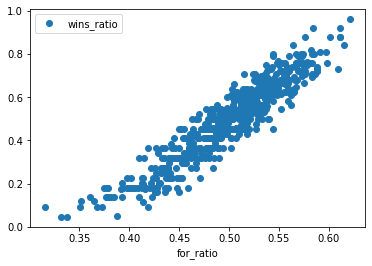

In [19]:
ax = df_seasonal.plot(x='for_ratio', y='wins_ratio', style='o')

### League ranking

The league rankings give a measure of the relative strength of each team, with a higher rank (i.e. smaller rank index) indicating a stronger team, and a lower rank (i.e. larger rank index) indicating a weaker team.

In practice, the league rankings are computed round by round only during the minor rounds. At the end of the minor rounds, the top-half ranked teams enter into the finals rounds, with team match-ups dictated by ranking. 

However, since we have chosen to consider all matches, from both the minor rounds and finals rounds, then we shall compute an overall ranking at the end of each season.

In [20]:
df_seasonal['rank'] = 0

In [21]:
for season in all_seasons:
    df = df_seasonal[df_seasonal.season == season].copy()
    df['points'] = 4 * df.wins + 2 * df.draws
    df['percentage'] = 100 * df['for'] / df.against
    df.sort_values(['points', 'percentage'], ascending=False, inplace=True)
    df['rank'] = range(len(df))
    df['rank'] += 1
    df.sort_values('team', inplace=True)
    df_seasonal.loc[df_seasonal.season == season, 'rank'] = df['rank']

Since the number of teams varies per season, so too does the maximum rank. Thus, we should compute an adjusted rank that is comparable across different seasons. For convenience, we map the top-ranking team to a score of 1.0 and the bottom-ranking team to a score of 0.0.

In [22]:
ranks = df_seasonal['rank']
num_teams = df_seasonal.teams
scale = -1.0 / (num_teams - 1)
df_seasonal['rank_score'] = scale * (ranks - 1) + 1

In [23]:
df_seasonal

,season,team,games,wins,draws,losses,teams,wins_ratio,for,against,for_ratio,rank,rank_score
0,1990,Brisbane Bears,22,4,0,18,14,0.181818,1733,2426,0.416687,14,0.000000
1,1990,Carlton,22,11,0,11,14,0.5,2277,2187,0.510081,8,0.461538
2,1990,Collingwood,26,19,1,6,14,0.75,2798,2077,0.573949,1,1.000000
3,1990,Essendon,25,18,0,7,14,0.72,2742,2079,0.568762,2,0.923077
4,1990,Fitzroy,22,7,0,15,14,0.318182,1874,2389,0.439597,12,0.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2022,Richmond,17,9,0,8,18,0.529412,1631,1418,0.534929,8,0.588235
541,2022,St Kilda,17,9,0,8,18,0.529412,1333,1311,0.504160,10,0.470588
542,2022,Sydney,17,11,0,6,18,0.647059,1546,1280,0.547063,6,0.705882
543,2022,West Coast,17,2,0,15,18,0.117647,1084,1888,0.364738,17,0.058824


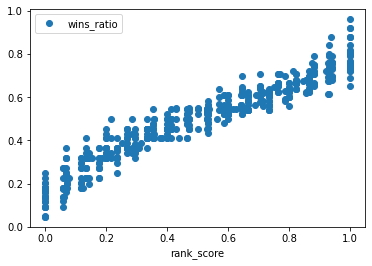

In [24]:
ax = df_seasonal.plot(x='rank_score', y='wins_ratio', style='o')

### Prestige scores

We now take each match in a given season as an edge in a graph with the teams as vertices. From this graph we may compute various analytics, including vertex scores.
Here we compute the flow prestige scores 
(see [Appendix B](B_graph_analytics.ipynb#Steady-state-flow-scores "Section: Steady-state flow scores")).

In [25]:
import numpy as np
from numpy.linalg import eig

In [26]:
df_seasonal['prestige'] = 0.0

In [27]:
for season in all_seasons:
    df = df_matches[df_matches.season == season]
    teams = sorted(set(df.for_team) | set(df.against_team))
    teams = { t: i for i, t in enumerate(teams) }
    num_teams = len(teams)
    points = np.zeros((num_teams, num_teams), dtype=int)
    games = np.zeros((num_teams, num_teams), dtype=int)
    for match in df.itertuples():
        i = teams[match.for_team]
        j = teams[match.against_team]
        points[i, j] += match.for_total_score
        games[i, j] += 1
        points[j, i] += match.against_total_score
        games[j, i] += 1
    # Compute flow matrix R of the graph
    games[games == 0] = 1  # prevent div 0
    R = points / games
    s = np.sum(R, axis=0)
    np.fill_diagonal(R, -s)
    w, v = eig(R)
    # Find eigenvector with zero eigenvalue
    idx = np.where(np.abs(w) <= 1e-6)[0][0]
    p = np.real(v[:, idx])
    p /= np.sum(p)
    df_seasonal.loc[df_seasonal.season == season, 'prestige'] = p

Note, however, that the prestige scores depend upon the number of teams, and hence are not directly comparable
across seasons.
We can instead use renormalised prestige scores 
(see 
[Appendix B](B_graph_analytics.ipynb#Probabilitistic-modelling "Section: Probabilitistic modelling"))
to estimate the probability of each team winning against an arbitrary opponent.

In [28]:
x = df_seasonal.prestige
x_bar = (1 - x) / (df_seasonal.teams - 1)
df_seasonal['adj_prestige'] = x / (x + x_bar)

In [29]:
df_seasonal

,season,team,games,wins,draws,losses,teams,wins_ratio,for,against,for_ratio,rank,rank_score,prestige,adj_prestige
0,1990,Brisbane Bears,22,4,0,18,14,0.181818,1733,2426,0.416687,14,0.000000,0.049030,0.401289
1,1990,Carlton,22,11,0,11,14,0.5,2277,2187,0.510081,8,0.461538,0.073333,0.507091
2,1990,Collingwood,26,19,1,6,14,0.75,2798,2077,0.573949,1,1.000000,0.096696,0.581871
3,1990,Essendon,25,18,0,7,14,0.72,2742,2079,0.568762,2,0.923077,0.096170,0.580403
4,1990,Fitzroy,22,7,0,15,14,0.318182,1874,2389,0.439597,12,0.153846,0.057674,0.443097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,2022,Richmond,17,9,0,8,18,0.529412,1631,1418,0.534929,8,0.588235,0.058767,0.514896
541,2022,St Kilda,17,9,0,8,18,0.529412,1333,1311,0.504160,10,0.470588,0.057077,0.507158
542,2022,Sydney,17,11,0,6,18,0.647059,1546,1280,0.547063,6,0.705882,0.065234,0.542620
543,2022,West Coast,17,2,0,15,18,0.117647,1084,1888,0.364738,17,0.058824,0.032211,0.361357


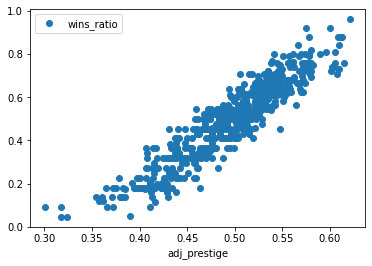

In [30]:
ax = df_seasonal.plot(x='adj_prestige', y='wins_ratio', style='o')

### Save the seasonal features

In [31]:
df_seasonal.to_csv(os.path.join("..", "data", "seasonal.csv"), index=False)